In [5]:
%matplotlib inline
import sys
import copy
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
import model

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

from dataproviders import parameters, agromanagement, weather
wofost = Wofost72_WLP_FD(parameters, weather, agromanagement)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output()).set_index("day")

This notebook was built with:
python version: 3.9.19 (main, Apr  6 2024, 17:57:55) 
[GCC 9.4.0]
PCSE version: 5.5.6


In [14]:
sys.modules.pop('model')

scenario_file = 'wofost.toml'
instance = list(pypfilt.load_instances(scenario_file))[0]
obs_tables = pypfilt.simulate_from_model(instance)

In [15]:
sys.modules.pop('model')

scenario_file = 'wofost.toml'
instance = list(pypfilt.load_instances(scenario_file))[0]
context = instance.build_context()
results = pypfilt.fit(context, filename=None)

In [16]:
sys.modules.pop('model')

scenario_file = 'wofost.toml'
instance = list(pypfilt.load_instances(scenario_file))[0]
forecast_time = 100
context = instance.build_context()
forecast_results = pypfilt.forecast(context, [forecast_time], filename=None)
fit = forecast_results.estimation.tables['forecasts']
forecast = forecast_results.forecasts[forecast_time].tables['forecasts']

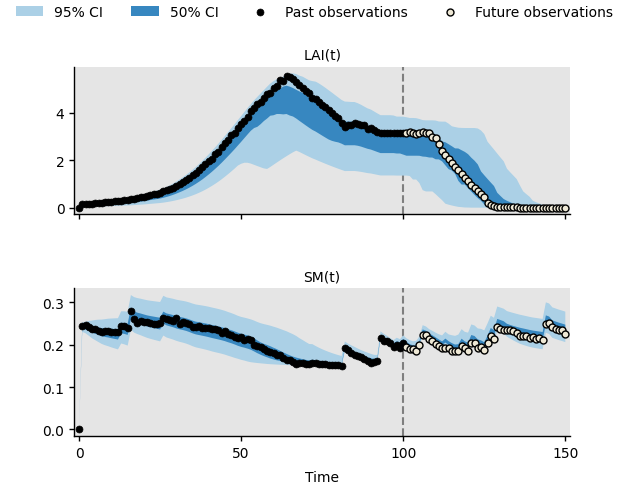

In [19]:
import pypfilt.plot
import matplotlib.pyplot as plt

backcast_time = 0

credible_intervals = np.concatenate(
    (fit[fit['time'] >= backcast_time], forecast)
)

backcast_obs = {
    unit: table[
        np.logical_and(
            table['time'] >= backcast_time,
            table['time'] <= forecast_time,
        )
    ]
    for (unit, table) in obs_tables.items()
}
 
# Collect the simulated observations over the forecast horizon.
future_obs = {
    unit: table[table['time'] > forecast_time]
    for (unit, table) in obs_tables.items()
}

# Plot the backcast and forecast against the simulated observations.
with pypfilt.plot.apply_style():
    plot = pypfilt.plot.Wrap(
        credible_intervals,
        'Time',
        '',
        ('unit', lambda s: '{}(t)'.format(s)),
        nc=1,
    )

    plot.expand_x_lims('time')
    plot.expand_y_lims('ymax')
    plot.fig.subplots_adjust(hspace=0.5)

    obs_size = 25.0

    for ax, df in plot.subplots():
        # Plot each forecast credible interval.
        hs = pypfilt.plot.cred_ints(ax, df, 'time', 'prob')

        # Plot the observations up to the forecasting time.
        hs.extend(
            pypfilt.plot.observations(
                ax,
                backcast_obs[df['unit'][0]],
                label='Past observations',
                s=obs_size,
            )
        )

        # Plot the observations after the forecasting time.
        hs.extend(
            pypfilt.plot.observations(
                ax,
                future_obs[df['unit'][0]],
                future=True,
                label='Future observations',
                s=obs_size,
            )
        )

        plot.add_to_legend(hs)

        # Add a vertical line to indicate the forecast time.
        ax.axvline(
            x=forecast_time, linestyle='--', color='#7f7f7f', zorder=0
        )

        # Adjust the axis limits and the number of ticks.
        x_range = df['time'].max() - df['time'].min()
        x_expand = x_range * 0.01
        ax.set_xlim(
            left=df['time'].min() - x_expand,
            right=df['time'].max() + x_expand,
        )
        ax.locator_params(axis='x', nbins=6)
        ax.set_ylim(auto=True)
        ax.locator_params(axis='y', nbins=6)

    plot.legend(loc='upper center', ncol=4, borderaxespad=0)
    plt.show()

In [4]:
scenario_file = 'gaussian.toml'
instance = list(pypfilt.load_instances(scenario_file))[0]
obs_tables = pypfilt.simulate_from_model(instance)
obs_tables

{'x': array([( 0., 0.4307412 ), ( 1., 0.43158935), ( 2., 0.41365349),
        ( 3., 0.44326487), ( 4., 0.42654793), ( 5., 0.42917344),
        ( 6., 0.41270181), ( 7., 0.3829194 ), ( 8., 0.39471599),
        ( 9., 0.37716175), (10., 0.36323401), (11., 0.39622215),
        (12., 0.40697156), (13., 0.41427159), (14., 0.41551963),
        (15., 0.42823379), (16., 0.42359184), (17., 0.41658668),
        (18., 0.40720055), (19., 0.43548837), (20., 0.402625  ),
        (21., 0.39192625), (22., 0.3870845 ), (23., 0.40719646),
        (24., 0.41884413), (25., 0.39147532), (26., 0.402359  ),
        (27., 0.41043751), (28., 0.41260549), (29., 0.41532422),
        (30., 0.40132728)], dtype=[('time', '<f8'), ('value', '<f8')])}

In [10]:
sys.modules.pop('model')

scenario_file = 'gaussian.toml'
instance = list(pypfilt.load_instances(scenario_file))[0]
forecast_time = 15
context = instance.build_context()
results = pypfilt.fit(context, filename=None)

In [17]:
sys.modules.pop('model')
scenario_file = 'gaussian.toml'
instance = list(pypfilt.load_instances(scenario_file))[0]
forecast_time = 15
context = instance.build_context()
pypfilt.forecast(context, [forecast_time], filename=None)

0.24863106652302086
0.2727188469958959
0.2755904462744814
0.2680743724033312
0.2653472157227816
0.26737728028410906
0.26529360335112134
0.2544782592745649
0.25382490566372173
0.2722749180363925
0.275086897639581
0.26097648700523546
0.27580823723165787
0.2767532268501001
0.2802060056123453
0.2819878533903042


Results(estimation=None, forecasts={15.0: Result(settings={'components': {'model': 'model.GaussianWalk', 'time': 'pypfilt.Scalar', 'sampler': 'pypfilt.sampler.LatinHypercube', 'summary': 'pypfilt.summary.HDF5'}, 'time': {'start': 0.0, 'until': 30.0, 'steps_per_unit': 1, 'summaries_per_unit': 1, 'dt': 1.0, 'epoch': 0.0, 'sim_start': 15.0, 'sim_until': 30.0}, 'prior': {'x': {'name': 'uniform', 'args': {'loc': 0, 'scale': 1}}}, 'observations': {'x': {'model': 'model.GaussianObs', 'parameters': {'sdev': 0.01}}}, 'filter': {'particles': 500, 'prng_seed': 2001, 'history_window': -1, 'resample': {'threshold': 0.25, 'enabled': True, 'method': 'deterministic', 'before_forecasting': False}, 'regularisation': {'bounds': {'x': {'min': -50, 'max': 50}}, 'enabled': False, 'bandwidth_scale': 0.5, 'regularise_or_fail': False, 'tolerance': 1e-08}, 'reweight_or_fail': False, 'reweight': {'enabled': True, 'exponent': 1.0}, 'adaptive_fit': {'enabled': False, 'target_effective_fraction': 0.5, 'exponent_tol

In [12]:
pypfilt.fit(context, filename=None)

Results(estimation=Result(settings={'components': {'model': 'model.GaussianWalk', 'time': 'pypfilt.Scalar', 'sampler': 'pypfilt.sampler.LatinHypercube', 'summary': 'pypfilt.summary.HDF5'}, 'time': {'start': 0.0, 'until': 30.0, 'steps_per_unit': 1, 'summaries_per_unit': 1, 'dt': 1.0, 'epoch': 0.0, 'sim_start': 0.0, 'sim_until': 30.0}, 'prior': {'x': {'name': 'uniform', 'args': {'loc': 0, 'scale': 1}}}, 'observations': {'x': {'model': 'model.GaussianObs', 'parameters': {'sdev': 0.01}}}, 'filter': {'particles': 500, 'prng_seed': 2001, 'history_window': -1, 'resample': {'threshold': 0.25, 'enabled': True, 'method': 'deterministic', 'before_forecasting': False}, 'regularisation': {'bounds': {'x': {'min': -50, 'max': 50}}, 'enabled': False, 'bandwidth_scale': 0.5, 'regularise_or_fail': False, 'tolerance': 1e-08}, 'reweight_or_fail': False, 'reweight': {'enabled': True, 'exponent': 1.0}, 'adaptive_fit': {'enabled': False, 'target_effective_fraction': 0.5, 'exponent_tolerance': 0.001}, 'result

In [8]:
import pypfilt

class Lorenz63(pypfilt.OdeModel):
    def field_types(self, ctx):
        r"""
        Define the state vector :math:`[\sigma, \rho, \beta, x, y, z]^T`.
        """
        return [
            ('sigma', float),
            ('rho', float),
            ('beta', float),
            ('x', float),
            ('y', float),
            ('z', float),
        ]

    def d_dt(self, time, xt, ctx, is_forecast):
        """
        The right-hand side of the ODE system.

        :param time: The current time.
        :param xt: The particle state vectors.
        :param ctx: The simulation context.
        :param is_forecast: True if this is a forecasting simulation.
        """
        rates = np.zeros(xt.shape, xt.dtype)
        rates['x'] = xt['sigma'] * (xt['y'] - xt['x'])
        rates['y'] = xt['x'] * (xt['rho'] - xt['z']) - xt['y']
        rates['z'] = xt['x'] * xt['y'] - xt['beta'] * xt['z']
        return rates

class ObsLorenz63(pypfilt.obs.Univariate):

    def distribution(self, ctx, snapshot):
        expect = snapshot.state_vec[self.unit]
        return scipy.stats.norm(loc=expect, scale=1.5)

In [9]:
def check_lorenz63_instances():
    """Ensure that the example Lorenz-63 file defines a single scenario."""
    scenario_file = 'lorenz63_simulate.toml'
    instances = list(pypfilt.load_instances(scenario_file))
    assert len(instances) == 1

def simulate_lorenz63_observations():
    scenario_file = 'lorenz63_simulate.toml'
    instances = list(pypfilt.load_instances(scenario_file))
    instance = instances[0]

    # Simulate observations for x(t), y(t), and z(t).
    obs_tables = pypfilt.simulate_from_model(instance)

    # Save the observations to plain-text files.
    for obs_unit, obs_table in obs_tables.items():
        out_file = f'lorenz63-{obs_unit}.ssv'
        pypfilt.io.write_table(out_file, obs_table)

    return obs_tables

check_lorenz63_instances()

In [10]:
def run_lorenz63_forecast(filename=None):
    scenario_file = 'lorenz63_forecast.toml'
    instances = list(pypfilt.load_instances(scenario_file))
    instance = instances[0]

    # Run a forecast from t = 20.
    forecast_time = 20
    context = instance.build_context()
    return pypfilt.forecast(context, [forecast_time], filename=filename)

run_lorenz63_forecast()

Results(estimation=Result(settings={'components': {'model': 'pypfilt.examples.lorenz.Lorenz63', 'time': 'pypfilt.Scalar', 'sampler': 'pypfilt.sampler.LatinHypercube', 'summary': 'pypfilt.summary.HDF5'}, 'time': {'start': 0.0, 'until': 25.0, 'steps_per_unit': 10, 'summaries_per_unit': 10, 'dt': 0.1, 'epoch': 0.0, 'sim_start': 20.0, 'sim_until': 25.0}, 'prior': {'sigma': {'name': 'constant', 'args': {'value': 10}}, 'rho': {'name': 'constant', 'args': {'value': 28}}, 'beta': {'name': 'constant', 'args': {'value': 2.66667}}, 'x': {'name': 'uniform', 'args': {'loc': -5, 'scale': 10}}, 'y': {'name': 'uniform', 'args': {'loc': -5, 'scale': 10}}, 'z': {'name': 'uniform', 'args': {'loc': -5, 'scale': 10}}}, 'observations': {'x': {'model': 'pypfilt.examples.lorenz.ObsLorenz63', 'file': 'lorenz63-x.ssv', 'parameters': {}}, 'y': {'model': 'pypfilt.examples.lorenz.ObsLorenz63', 'file': 'lorenz63-y.ssv', 'parameters': {}}, 'z': {'model': 'pypfilt.examples.lorenz.ObsLorenz63', 'file': 'lorenz63-z.ssv

In [7]:
class Lorenz63(pypfilt.OdeModel):
    def field_types(self, ctx):
        r"""
        Define the state vector :math:`[\sigma, \rho, \beta, x, y, z]^T`.
        """
        return [
            ('sigma', float),
            ('rho', float),
            ('beta', float),
            ('x', float),
            ('y', float),
            ('z', float),
        ]

    def d_dt(self, time, xt, ctx, is_forecast):
        """
        The right-hand side of the ODE system.

        :param time: The current time.
        :param xt: The particle state vectors.
        :param ctx: The simulation context.
        :param is_forecast: True if this is a forecasting simulation.
        """
        rates = np.zeros(xt.shape, xt.dtype)
        rates['x'] = xt['sigma'] * (xt['y'] - xt['x'])
        rates['y'] = xt['x'] * (xt['rho'] - xt['z']) - xt['y']
        rates['z'] = xt['x'] * xt['y'] - xt['beta'] * xt['z']
        return rates

    def can_smooth(self):
        """Indicate which state vector fields can be smoothed."""
        return {'sigma', 'rho', 'beta', 'x', 'y', 'z'}

def run_lorenz63_forecast_regularised(filename=None):
    scenario_file = 'lorenz63_forecast_regularised.toml'
    instances = list(pypfilt.load_instances(scenario_file))
    instance = instances[0]

    # Run a forecast from t = 20.
    forecast_time = 20
    context = instance.build_context()
    return pypfilt.forecast(context, [forecast_time], filename=filename)

run_lorenz63_forecast_regularised()

Results(estimation=Result(settings={'components': {'model': 'pypfilt.examples.lorenz.Lorenz63', 'time': 'pypfilt.Scalar', 'sampler': 'pypfilt.sampler.LatinHypercube', 'summary': 'pypfilt.summary.HDF5'}, 'time': {'start': 0.0, 'until': 25.0, 'steps_per_unit': 10, 'summaries_per_unit': 10, 'dt': 0.1, 'epoch': 0.0, 'sim_start': 20.0, 'sim_until': 25.0}, 'prior': {'sigma': {'name': 'constant', 'args': {'value': 10}}, 'rho': {'name': 'constant', 'args': {'value': 28}}, 'beta': {'name': 'constant', 'args': {'value': 2.66667}}, 'x': {'name': 'uniform', 'args': {'loc': -5, 'scale': 10}}, 'y': {'name': 'uniform', 'args': {'loc': -5, 'scale': 10}}, 'z': {'name': 'uniform', 'args': {'loc': -5, 'scale': 10}}}, 'summary': {'tables': {'forecasts': {'component': 'pypfilt.summary.PredictiveCIs', 'credible_intervals': [50, 60, 70, 80, 90, 95]}, 'sim_z': {'component': 'pypfilt.summary.SimulatedObs', 'observation_unit': 'z'}}, 'save_history': False, 'only_forecasts': False, 'metadata': {'packages': []}},

In [11]:
import pypfilt.crps

def score_lorenz63_forecasts():
    """Calculate CRPS values for the simulated `z(t)` observations."""
    # Load the true observations that occur after the forecasting time.
    columns = [('time', float), ('value', float)]
    z_true = pypfilt.io.read_table('lorenz63-z.ssv', columns)
    z_true = z_true[z_true['time'] > 20]

    # Run the original forecasts.
    fs_file = 'lorenz63_forecast.hdf5'
    fs = run_lorenz63_forecast(filename=fs_file)

    # Run the forecasts with regularisation.
    reg_file = 'lorenz63_regularised.hdf5'
    fs_reg = run_lorenz63_forecast_regularised(filename=reg_file)

    # Extract the simulated z(t) observations for each forecast.
    time = pypfilt.Scalar()
    z_table = '/tables/sim_z'
    z_fs = pypfilt.io.load_summary_table(time, fs_file, z_table)
    z_reg = pypfilt.io.load_summary_table(time, reg_file, z_table)

    # Calculate CRPS values for each forecast.
    crps_fs = pypfilt.crps.simulated_obs_crps(z_true, z_fs)
    crps_reg = pypfilt.crps.simulated_obs_crps(z_true, z_reg)

    # Check that regularisation improved the forecast performance.
    assert np.mean(crps_reg['score']) < np.mean(crps_fs['score'])

    # Compare the CRPS values for each forecast.
    return (fs, fs_reg)

score_lorenz63_forecasts()

(Results(estimation=Result(settings={'components': {'model': 'pypfilt.examples.lorenz.Lorenz63', 'time': 'pypfilt.Scalar', 'sampler': 'pypfilt.sampler.LatinHypercube', 'summary': 'pypfilt.summary.HDF5'}, 'time': {'start': 0.0, 'until': 25.0, 'steps_per_unit': 10, 'summaries_per_unit': 10, 'dt': 0.1, 'epoch': 0.0, 'sim_start': 20.0, 'sim_until': 25.0}, 'prior': {'sigma': {'name': 'constant', 'args': {'value': 10}}, 'rho': {'name': 'constant', 'args': {'value': 28}}, 'beta': {'name': 'constant', 'args': {'value': 2.66667}}, 'x': {'name': 'uniform', 'args': {'loc': -5, 'scale': 10}}, 'y': {'name': 'uniform', 'args': {'loc': -5, 'scale': 10}}, 'z': {'name': 'uniform', 'args': {'loc': -5, 'scale': 10}}}, 'observations': {'x': {'model': 'pypfilt.examples.lorenz.ObsLorenz63', 'file': 'lorenz63-x.ssv', 'parameters': {}}, 'y': {'model': 'pypfilt.examples.lorenz.ObsLorenz63', 'file': 'lorenz63-y.ssv', 'parameters': {}}, 'z': {'model': 'pypfilt.examples.lorenz.ObsLorenz63', 'file': 'lorenz63-z.ss